In [1]:
import py21cmfast as p21c
print("py21cmfast version:", p21c.__version__)

/home/akshat/miniforge3/envs/21cmfast/lib/python3.11/site-packages/py21cmfast/_cfg.py:57: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/home/akshat/miniforge3/envs/21cmfast/lib/python3.11/site-packages/py21cmfast/_cfg.py:41: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


py21cmfast version: 3.3.1


In [3]:
import os
if not os.path.exists('_cache'):
    os.mkdir('_cache')

p21c.config['direc'] = '_cache'
p21c.cache_tools.clear_cache(direc="_cache")

In [ ]:
initial_conditions = p21c.initial_conditions(
    user_params = {"HII_DIM": 100, "BOX_LEN": 100, "USE_INTERPOLATION_TABLES": True},
    cosmo_params = p21c.CosmoParams(SIGMA_8=0.8),
    random_seed=12225
)

In [5]:
# ---- redshift grid: 6.0, 5.5, ..., 2.0 ----
import numpy as np
redshifts = np.arange(6.0, 1.999, -0.5)  # stop chosen to include 2.0 robustly
Nz = len(redshifts)

# ---- your box setup ----
HII_DIM = 100
BOX_LEN = 100.0  # comoving Mpc (as you are using)
seed = 12345

# middle sightline
y0 = HII_DIM // 2  # 50
z0 = HII_DIM // 2  # 50

# Ensure we keep velocity_x/velocity_y/velocity_z
user_params = {
    "HII_DIM": HII_DIM,
    "BOX_LEN": BOX_LEN,
    "USE_INTERPOLATION_TABLES": True
}

cosmo_params = p21c.CosmoParams(SIGMA_8=0.8)
astro_params = p21c.AstroParams({"HII_EFF_FACTOR": 20.0})

# ---- allocate output arrays: (Nz, Nx) ----
delta_b = np.empty((Nz, HII_DIM), dtype=np.float32)  # Delta = rho/rho_mean
v_kms          = np.empty((Nz, HII_DIM), dtype=np.float32)  # v_x along LOS
T_K           = np.empty((Nz, HII_DIM), dtype=np.float32)  # temp_kinetic_all_gas along LOS

# NOTE: assumes you already have initial_conditions defined and compatible with these params
# initial_conditions = p21c.initial_conditions(user_params=user_params, cosmo_params=cosmo_params, random_seed=seed)

for iz, z in enumerate(redshifts):
    z = float(z)

    # Full coeval (for temperature field)
    coeval = p21c.run_coeval(
        redshift=z,
        user_params=user_params,
        cosmo_params=cosmo_params,
        astro_params=astro_params,
        random_seed=seed
    )

    # Perturbed field (for density + vx)
    perturbed_field = p21c.perturb_field(
        redshift=z,
        user_params=user_params,
        cosmo_params=cosmo_params,
        random_seed=seed
    )

    ionized_field = p21c.ionize_box(
    perturbed_field = perturbed_field)

    # density is the density contrast delta = rho/rho_mean - 1
    T0 = 10000
    gamma = 1.5
    y0, z0 = 50, 50  # fixed indices
    density_1d = perturbed_field.density[:, y0, z0]
    overdensity_1d = 1.0 + density_1d
    vlos_1d    = coeval.lowres_vx[:, y0, z0]  # z-component/LOS component
    T_1d       = T0*((overdensity_1d)**(gamma))#ionized_field.temp_kinetic_all_gas[:, y0, z0]

    delta_b[iz, :] = overdensity_1d.astype(np.float32)
    v_kms[iz, :] = vlos_1d.astype(np.float32)
    T_K[iz, :] = T_1d.astype(np.float32)

# At this point you have:
#   redshifts          : (Nz,)
#   overdensity_los    : (Nz, HII_DIM)
#   vx_los             : (Nz, HII_DIM)
#   T_los              : (Nz, HII_DIM)

/home/akshat/miniforge3/envs/21cmfast/lib/python3.11/site-packages/py21cmfast/_utils.py:400: UserWarning: The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
  warnings.warn(
/home/akshat/miniforge3/envs/21cmfast/lib/python3.11/site-packages/py21cmfast/_utils.py:815: UserWarning: Trying to remove array that isn't yet created: hires_vx
  warnings.warn(f"Trying to remove array that isn't yet created: {k}")
/home/akshat/miniforge3/envs/21cmfast/lib/python3.11/site-packages/py21cmfast/_utils.py:815: UserWarning: Trying to remove array that isn't yet created: hires_vy
  warnings.warn(f"Trying to remove array that isn't yet created: {k}")
/home/akshat/miniforge3/envs/21cmfast/lib/python3.11/site-packages/py21cmfast/_utils.py:815: UserWarning: Trying to remove array that isn't yet created: hires_vz
  warnings.warn(f"Trying to remove array that isn't yet created: {k}")
/home/akshat/miniforge3/envs/21cmfast/lib/python3.11/site-packages/py21cmfast/_utils.py:815: UserWarni

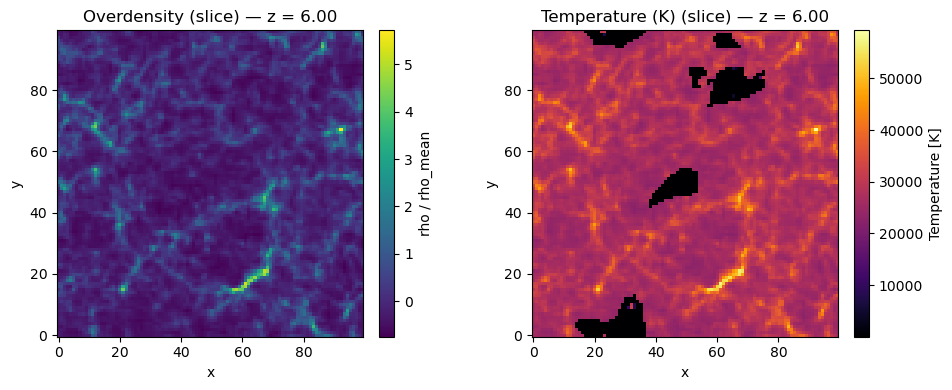

In [7]:
import matplotlib.pyplot as plt

# choose which redshift index to plot (0..Nz-1)
iz = 0
z = float(redshifts[iz])

# re-run the fields for this redshift (use same params / seed as before)
coeval = p21c.run_coeval(
    redshift=z,
    user_params=user_params,
    cosmo_params=cosmo_params,
    astro_params=astro_params,
    random_seed=seed
)
perturbed_field = p21c.perturb_field(
    redshift=z,
    user_params=user_params,
    cosmo_params=cosmo_params,
    random_seed=seed
)
ionized_field = p21c.ionize_box(perturbed_field=perturbed_field)

# take a 2D slice through the box (middle index along the 3rd axis)
mid = HII_DIM // 2
density_slice = perturbed_field.density[:, :, mid]                # shape (HII_DIM, HII_DIM)
temp_slice    = ionized_field.temp_kinetic_all_gas[:, :, mid]     # shape (HII_DIM, HII_DIM)

# plot side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

im0 = axes[0].imshow(density_slice.T, origin='lower', aspect='equal')
axes[0].set_title(f'Overdensity (slice) — z = {z:.2f}')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
cbar0 = fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
cbar0.set_label('rho / rho_mean')

im1 = axes[1].imshow(temp_slice.T, origin='lower', aspect='equal', cmap='inferno')
axes[1].set_title(f'Temperature (K) (slice) — z = {z:.2f}')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
cbar1 = fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
cbar1.set_label('Temperature [K]')

plt.tight_layout()
plt.show()


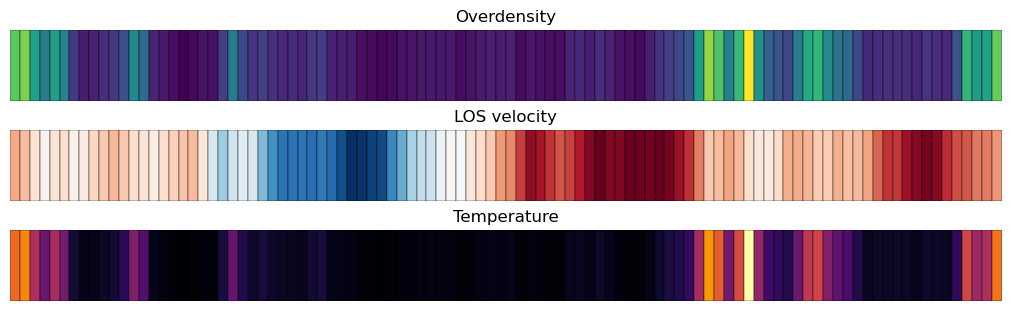

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# choose redshift index
iz = 3

def draw_cube_row(ax, values, cmap):
    norm = plt.Normalize(values.min(), values.max())
    cmap = plt.get_cmap(cmap)

    for i, val in enumerate(values):
        color = cmap(norm(val))
        rect = patches.Rectangle((i, 0), 1, 1,
                                 facecolor=color,
                                 edgecolor='black',
                                 linewidth=0.3)
        ax.add_patch(rect)

    ax.set_xlim(0, len(values))
    ax.set_ylim(0, 1)
    ax.axis('off')

fig, axes = plt.subplots(3, 1, figsize=(10, 3), constrained_layout=True)

draw_cube_row(axes[0], delta_b[iz], 'viridis')
axes[0].set_title("Overdensity")

draw_cube_row(axes[1], v_kms[iz], 'RdBu_r')
axes[1].set_title("LOS velocity")

draw_cube_row(axes[2], T_K[iz], 'inferno')
axes[2].set_title("Temperature")

plt.show()


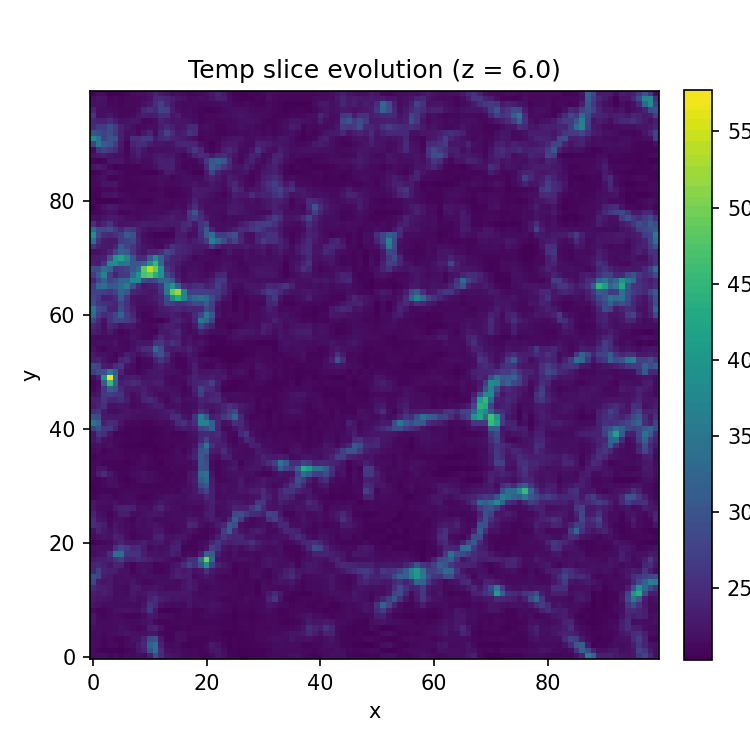

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from io import BytesIO
from IPython.display import Image as IPyImage, display

frames = []

mid = HII_DIM // 2

for z in redshifts:
    z = float(z)

    perturbed_field = p21c.perturb_field(
        redshift=z,
        user_params=user_params,
        cosmo_params=cosmo_params,
        random_seed=seed
    )

    density_slice = perturbed_field.density[:, :, mid]
    temp_slice    = ionized_field.temp_kinetic_all_gas[:, :, mid]   

    fig, ax = plt.subplots(figsize=(5, 5), dpi=150)

    im = ax.imshow(temp_slice.T,
                   origin='lower',
                   aspect='equal',
                   cmap='viridis')

    ax.set_title(f"Temp slice evolution (z = {z:.1f})")
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    fig.subplots_adjust(left=0.12, right=0.95, bottom=0.12, top=0.88)

    buf = BytesIO()
    fig.savefig(buf, format="png")
    plt.close(fig)
    buf.seek(0)

    frame = imageio.imread(buf)
    if frame.ndim == 3 and frame.shape[2] == 4:
        frame = frame[:, :, :3]

    frames.append(frame)

gif_path = "temp_slice_evolution.gif"
imageio.mimsave(gif_path, frames, duration=500.0)

display(IPyImage(filename=gif_path))
